# NOTEBOOK 1

In [1]:
import pandas as pd
import os
import time
import numpy as np
import arcgis
from astral import Astral
from datetime import datetime, timedelta

In [3]:
project_gdb = r'D:\Model_R\Model_R\Model_R.gdb'
collisions_path = os.path.join(project_gdb,'collisions_joined_1')
road_features_path = os.path.join(project_gdb,'SRF')

In [4]:
df = arcgis.features.SpatialDataFrame().from_featureclass(collisions_path)


C:\Users\maram\Anaconda3\envs\t\lib\site-packages\arcgis\features\_data\geodataset\geodataframe.py:221: UserWarning: SpatialDataFrame has been deprecated.  Please switch to the GeoAccessor/GeoSeriesAccessor.
  warnings.warn("SpatialDataFrame has been deprecated.  Please switch to the GeoAccessor/GeoSeriesAccessor.")


In [5]:
df.head()


,OBJECTID,Join_Count,TARGET_FID,CRASHID,CRASHDATE,CRASHTIME,Latitude,Longitude,Make,DriverAge,Gender,WeatherDesc,segment_id,hour,year,SHAPE
0,1,1,1,RD3112131018,1/1/2014,0:00:15,24.594873,46.756898,None,NaN,Male,None,95449,95449,2014,"{'x': 677879.9221999999, 'y': 2721223.26060000..."
1,2,1,2,RD3112131018,1/1/2014,0:00:15,24.594873,46.756898,Lexus,26.0,Male,None,95449,95449,2014,"{'x': 677879.9221999999, 'y': 2721223.26060000..."
2,3,1,3,RD01011412,1/1/2014,0:29:30,24.577508,46.676487,GMC,21.0,Male,None,64654,64654,2014,"{'x': 669764.9375999998, 'y': 2719201.42740000..."
3,4,1,4,RD01011412,1/1/2014,0:29:30,24.577508,46.676487,Hyundai,53.0,Male,None,64654,64654,2014,"{'x': 669764.9375999998, 'y': 2719201.42740000..."
4,5,1,5,RD01011414,1/1/2014,0:40:49,24.709105,46.814151,Isuzu,39.0,Male,None,72609,72609,2014,"{'x': 683512.4345000004, 'y': 2733951.23530000..."


In [6]:
rdf = arcgis.features.SpatialDataFrame().from_featureclass(road_features_path)


In [7]:
# We don't care about accidents that happened far from known major/minor roads
df = df.dropna(how='any',subset=['segment_id'])

# Convert some types
df['segment_id'] = df.segment_id.astype('int64')
rdf['segment_id'] = rdf.segment_id.astype('int64') 
rdf['station_id'] = rdf.station_id.astype('int64') # Weather statiion ID

In [8]:

df['CRASHDATE'] = df['CRASHDATE'].astype('str')
df['CRASHTIME'] = df['CRASHTIME'].astype('str')

df['timestamp'] = pd.to_datetime(df['CRASHDATE']+' '+df['CRASHTIME'])

time_index = pd.DatetimeIndex(df.timestamp).floor('1h')
df['hour'] = time_index.hour
df['weekday'] = time_index.weekday
df['month'] = time_index.month
if not os.path.exists('training_data'):
    os.mkdir('training_data')
df.to_csv('training_data/collisions.csv')

In [9]:
rdf.loc[pd.isna(rdf.speed_limit),'speed_limit'] = np.median(rdf.speed_limit)
rdf.loc[pd.isna(rdf.aadt),'aadt'] = 0.0 # AKA, unknown, zero, etc. This will help differentiate major/minor roadways

C:\Users\maram\Anaconda3\envs\t\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [10]:
accident_counts_per_segment = df.groupby('segment_id').size().reset_index(name='accident_counts').set_index('segment_id')

In [11]:
rdf = rdf.set_index('segment_id').join(accident_counts_per_segment)

In [12]:
# If there was no accident, set value to 0, not NaN
rdf.loc[pd.isna(rdf.accident_counts),'accident_counts'] = 0.0

In [13]:
print(rdf.columns.tolist())

['OBJECTID', 'Join_Count', 'TARGET_FID', 'Join_Count_1', 'TARGET_FID_1', 'Join_Count_12', 'TARGET_FID_12', 'street_type', 'surface_type', 'suf_dir', 'one_way', 'speed_limit', 'surface_width', 'aadt', 'sinuosity', 'euclidean_length', 'segment_length', 'at_intersection', 'at_exit', 'near_billboard', 'road_orient_approx', 'proximity_to_signal', 'proximity_to_billboard', 'proximity_to_nearest_intersection', 'proximity_to_nearest_exit', 'proximity_to_major_road', 'population_density', 'Hopspot', 'station_id', 'SHAPE', 'accident_counts']


In [17]:
static_feature_names = [
    'street_type',
    'suf_dir', 
    'one_way', 
    'speed_limit', 
    'surface_type', 
    'surface_width', 
    'aadt', 
    'sinuosity',          # \
    'euclidean_length',   # |  These together define road curvature
    'segment_length',     # /
    'road_orient_approx', 
    'at_intersection',
    'at_exit',
    'proximity_to_billboard',
    'proximity_to_major_road',
    'proximity_to_signal',
    'proximity_to_nearest_intersection',
    'proximity_to_nearest_exit',
    'population_density',
    'Hopspot',
    'accident_counts'
]
temporal_feature_names = [
    'hour',
    'weekday',
    'month'
]

In [18]:

features = df\
    .xs(['timestamp','segment_id']+temporal_feature_names,axis=1)\
    .set_index('segment_id')\
    .join(
        rdf.xs(static_feature_names+['station_id'],axis=1),
        how='left'
    ).reset_index()

In [19]:
features.head()


,segment_id,timestamp,hour,weekday,month,street_type,suf_dir,one_way,speed_limit,surface_type,...,at_exit,proximity_to_billboard,proximity_to_major_road,proximity_to_signal,proximity_to_nearest_intersection,proximity_to_nearest_exit,population_density,Hopspot,accident_counts,station_id
0,3,2014-04-01 13:35:37,13,1,4,ST,None,B,30.0,PAVED,...,0,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999
1,3,2014-04-01 13:35:37,13,1,4,ST,None,B,30.0,PAVED,...,0,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999
2,3,2014-04-07 00:36:40,0,0,4,ST,None,B,30.0,PAVED,...,0,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999
3,3,2014-04-07 00:36:40,0,0,4,ST,None,B,30.0,PAVED,...,0,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999
4,3,2014-04-13 19:32:44,19,6,4,ST,None,B,30.0,PAVED,...,0,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999


In [20]:

time_index = pd.DatetimeIndex(features.timestamp).floor('1h')
feature_timestamp_series = time_index.to_series()
segment_id = features.segment_id.astype('str')

# Floor to nearest hour
features['timestamp'] = feature_timestamp_series.values

# Index for fast lookup
features['fid'] = feature_timestamp_series.map(lambda x:str(int(x.timestamp()))).values + segment_id.values
features.set_index('fid',inplace=True)

# Set target value
features['target'] = 1

In [21]:
features.head()


,segment_id,timestamp,hour,weekday,month,street_type,suf_dir,one_way,speed_limit,surface_type,...,proximity_to_billboard,proximity_to_major_road,proximity_to_signal,proximity_to_nearest_intersection,proximity_to_nearest_exit,population_density,Hopspot,accident_counts,station_id,target
fid,,,,,,,,,,,,,,,,,,,,,
13963572003,3,2014-04-01 13:00:00,13,1,4,ST,None,B,30.0,PAVED,...,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999,1
13963572003,3,2014-04-01 13:00:00,13,1,4,ST,None,B,30.0,PAVED,...,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999,1
13968288003,3,2014-04-07 00:00:00,0,0,4,ST,None,B,30.0,PAVED,...,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999,1
13968288003,3,2014-04-07 00:00:00,0,0,4,ST,None,B,30.0,PAVED,...,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999,1
13974156003,3,2014-04-13 19:00:00,19,6,4,ST,None,B,30.0,PAVED,...,208.698728,0.0,96.769849,0.0,290.061,26.663902,100,117.0,40488099999,1


In [22]:
class NegativeSampler:
    """
    Given features (positive examples), roads, times and the number of samples to draw, draws a sample
    """
    def __init__(self,num_samples,
                 accidents,roads,
                 static_feature_names,
                 seed=None):

        self.roads = roads
        self.accidents = accidents
        self.num_samples = num_samples
        
        self.static_feature_names = static_feature_names
        
        if seed:
            np.random.seed(seed)
    
    def sample(self):
        segment_ids = self.roads.index.to_series()
        
        altered = pd.DataFrame()
        num_to_sample = self.num_samples
        
        while num_to_sample > 0:
            samples = self.accidents[['timestamp','segment_id']].sample(n=num_to_sample,replace=True).reset_index()
            sample_timestamps,sample_segment_ids = self._mod(samples.copy(),segment_ids,1.0/(self.roads.accident_counts+1))
            # Create an index
            
            timestamp_strings = sample_timestamps.map(lambda x:str(int(x.timestamp()))).values
            segment_id_strings = sample_segment_ids.values.astype('str') 
        
            fid = timestamp_strings+segment_id_strings
            alt = pd.DataFrame({
                'timestamp': sample_timestamps.values,
                'segment_id': sample_segment_ids.values,
                'fid':fid
            }).set_index('fid')
            
            altered = altered.append(alt)

            # Which happened before? They shouldn't get negative samples
            intersection = altered.index.intersection(self.accidents.index)
            idxer = intersection.get_values()
            
            # Drop samples where accidents occurred.
            altered = altered.drop(idxer)
            
            num_to_sample = self.num_samples - altered.shape[0]
        
        
        altered['target'] = 0
        
        ts = pd.DatetimeIndex(altered.timestamp)
        segment_ids = altered.segment_id
        
        #altered = altered.reset_index()
        
        station_ids = self.roads.loc[segment_ids].station_id
        static_features = self.roads.loc[segment_ids][self.static_feature_names]
        for i,f in enumerate(self.static_feature_names):
            altered[f] = static_features.values[:,i]
        altered['station_id'] = station_ids.values
        altered['weekday'] = ts.weekday
        altered['month'] = ts.month
        altered['hour'] = ts.hour
        
        altered = altered.reset_index(drop=True)#.drop(columns=['fid'])
        return altered
    
    def _mod(self,samples,segment_ids,w=None):
        # Get the current timestamps
        ts = pd.DatetimeIndex(samples.timestamp)
        
        # Hour, Day, Year
        hour = ts.hour.to_series()
        day = ts.dayofyear.to_series()
        year = ts.year.to_series()

        # Road ID
        segment_id = samples.segment_id.copy()
        
        sample_segment_ids = pd.Series()
        sample_timestamps = pd.Series()
                                     
        # Index of samples to mutate
        #feat_i = np.random.randint(0,3,size=samples.shape[0])
        feat_i = np.random.choice([0,1,2],size=samples.shape[0],p=[0.1,0.3,0.6])
        ##########################
        # i == 0
        # Change hour of day
        idx = feat_i == 0
        samp_i = samples.loc[idx]
        N = samp_i.shape[0]

        # Sample until we have all different hours of the day
        num_same = N
        new_hours = hour.loc[idx].values.copy()
        dif_idx = np.ones(N,dtype='bool')
        
        while num_same != 0:
            
            new_hours[dif_idx] = np.random.choice(24,size=num_same)
            dif_idx = new_hours == hour.loc[idx].values
            dif_idx = dif_idx | ((new_hours - 1) == hour.loc[idx].values)
            dif_idx = dif_idx | ((new_hours + 1) == hour.loc[idx].values)
            num_same = dif_idx.sum()
       
        # Create new timestamps
        new_timestamps = year[idx].apply(pd.Timestamp,args=(1,1))
        new_timestamps = pd.DatetimeIndex(new_timestamps) 
        new_timestamps += pd.TimedeltaIndex(day[idx]-1,unit='D') # same day
        new_timestamps += pd.TimedeltaIndex(new_hours,unit='H') # new hour
        
        sample_segment_ids = sample_segment_ids.append(segment_id.loc[idx].copy())
        sample_timestamps = sample_timestamps.append(new_timestamps.to_series().copy())
        ##########################

        ##########################
        # i == 1
        # Change day of year
        idx = feat_i == 1
        samp_i = samples.loc[idx]
        N = samp_i.shape[0]

        is_leap_yr = ts[idx].is_leap_year

        # Sample until we have all different days of the year.
        num_same = N
        new_days = day.loc[idx].values.copy()
        dif_idx = np.ones(N,dtype='bool')
        while num_same != 0:
            # Pay attention to leap years
            dif_leap_yr = (dif_idx&is_leap_yr)
            dif_no_leap_yr = dif_idx&(~is_leap_yr)
            
            new_days[dif_leap_yr] = np.random.choice(np.arange(1,367,dtype='int'),size=dif_leap_yr.sum())
            new_days[dif_no_leap_yr] = np.random.choice(np.arange(1,366,dtype='int'),size=dif_no_leap_yr.sum())

            dif_idx = new_days == day.loc[idx].values
            num_same = dif_idx.sum()
        
        # Create new timestamps
        timestamps = year[idx].apply(pd.Timestamp,args=(1,1))
        new_timestamps = pd.DatetimeIndex(timestamps) 
        new_timestamps += pd.TimedeltaIndex(new_days-1,unit='D')  # new day
        new_timestamps += pd.TimedeltaIndex(hour[idx],unit='H') # same hour

        sample_segment_ids = sample_segment_ids.append(segment_id.loc[idx].copy())
        sample_timestamps = sample_timestamps.append(new_timestamps.to_series().copy())
        ##########################

        ##########################
        # i == 2
        # Change road
        idx = feat_i == 2
        samp_i = samples.loc[idx]
        N = samp_i.shape[0]

        num_same = N
        new_roads = segment_id.loc[idx].values.copy()
        dif_idx = np.ones(N,dtype='bool')

        while num_same != 0:
            new_roads[dif_idx] = segment_ids.sample(n=num_same,replace=True,weights=w).values
            dif_idx = new_roads == segment_id.loc[idx].values
            num_same = dif_idx.sum()
        
        sample_segment_ids = sample_segment_ids.append(pd.Series(new_roads))
        sample_timestamps = sample_timestamps.append(ts[idx].to_series().copy())
        
        
        sample_segment_ids = sample_segment_ids.astype('int64')     
        return sample_timestamps,sample_segment_ids

In [23]:
t = time.time()
N = features.shape[0]*6
ns = NegativeSampler(N,features,rdf,static_feature_names)

negative_examples = ns.sample().set_index(['timestamp','segment_id','station_id'])

print((time.time() - t),'seconds')

1902.929843902588 seconds


In [24]:
negative_examples.to_csv('training_data/riyadh_negative_examples.csv')


In [25]:
negative_examples.head()


,,,target,street_type,suf_dir,one_way,speed_limit,surface_type,surface_width,aadt,sinuosity,euclidean_length,...,proximity_to_major_road,proximity_to_signal,proximity_to_nearest_intersection,proximity_to_nearest_exit,population_density,Hopspot,accident_counts,weekday,month,hour
timestamp,segment_id,station_id,,,,,,,,,,,,,,,,,,,,,
2014-05-21 04:00:00,109265,40438099999,0,RD,W,FT,75,PAVED,100,309381,1.91244,85.0284,...,0,1934.01,0,27.6483,126.529,100,36,2,5,4
2014-10-09 19:00:00,103069,40437099999,0,BRG,W,FT,70,PAVED,84,659494,1.00008,2712.41,...,0,4.06636,0,5.19046,3.46044,100,2254,3,10,19
2016-04-20 00:00:00,78308,40441099999,0,ST,W,FT,30,PAVED,40,0,1,3055.53,...,2595.03,3535.13,0,3277.65,3.94109,100,686,2,4,0
2017-09-18 00:00:00,102652,40448099999,0,ST,W,FT,60,PAVED,40,0,1,2798.87,...,0,3717.07,0,912.059,10.7647,90,1570,0,9,0
2016-03-04 20:00:00,75817,40438099999,0,SRV,W,FT,50,PAVED,10,955937,1,183.333,...,0,46.8617,0,1980.99,105.731,100,29,4,3,20


In [26]:

# Reselect Features
positive_examples = df\
    .xs(['segment_id']+temporal_feature_names,axis=1)\
    .set_index('segment_id')\
    .join(
        rdf.xs(static_feature_names+['station_id'],axis=1),
        how='left'
    ).reset_index()
    
positive_examples = positive_examples.set_index([time_index.floor('1h'),'segment_id','station_id'])
positive_examples['target'] = 1
positive_examples.head()

hour  weekday  month street_type  \
timestamp           segment_id station_id                                      
2014-04-01 13:00:00 3          40488099999    13        1      4          ST   
                               40488099999    13        1      4          ST   
2014-04-07 00:00:00 3          40488099999     0        0      4          ST   
                               40488099999     0        0      4          ST   
2014-04-13 19:00:00 3          40488099999    19        6      4          ST   

                                           suf_dir one_way  speed_limit  \
timestamp           segment_id station_id                                 
2014-04-01 13:00:00 3          40488099999    None       B         30.0   
                               40488099999    None       B         30.0   
2014-04-07 00:00:00 3          40488099999    None       B         30.0   
                               40488099999    None       B         30.0   
2014-04-13 19:00:00 3          40488099999    None       B         30.0   

                                           surface_type  surface_width  aadt  \
timestamp           segment_id station_id                                      
2014-04-01 13:00:00 3          40488099999        PAVED           20.0   0.0   
                               40488099999        PAVED           20.0   0.0   
2014-04-07 00:00:00 3          40488099999        PAVED           20.0   0.0   
                               40488099999        PAVED           20.0   0.0   
2014-04-13 19:00:00 3          40488099999        PAVED           20.0   0.0   

                                            ...  at_exit  \
timestamp           segment_id station_id   ...            
2014-04-01 13:00:00 3          40488099999  ...        0   
                               40488099999  ...        0   
2014-04-07 00:00:00 3          40488099999  ...        0   
                               40488099999  ...        0   
2014-04-13 19:00:00 3          40488099999  ...        0   

                                            proximity_to_billboard  \
timestamp           segment_id station_id                            
2014-04-01 13:00:00 3          40488099999              208.698728   
                               40488099999              208.698728   
2014-04-07 00:00:00 3          40488099999              208.698728   
                               40488099999              208.698728   
2014-04-13 19:00:00 3          40488099999              208.698728   

                                            proximity_to_major_road  \
timestamp           segment_id station_id                             
2014-04-01 13:00:00 3          40488099999                      0.0   
                               40488099999                      0.0   
2014-04-07 00:00:00 3          40488099999                      0.0   
                               40488099999                      0.0   
2014-04-13 19:00:00 3          40488099999                      0.0   

                                            proximity_to_signal  \
timestamp           segment_id station_id                         
2014-04-01 13:00:00 3          40488099999            96.769849   
                               40488099999            96.769849   
2014-04-07 00:00:00 3          40488099999            96.769849   
                               40488099999            96.769849   
2014-04-13 19:00:00 3          40488099999            96.769849   

                                            proximity_to_nearest_intersection  \
timestamp           segment_id station_id                                       
2014-04-01 13:00:00 3          40488099999                                0.0   
                               40488099999                                0.0   
2014-04-07 00:00:00 3          40488099999                                0.0   
                               40488099999                                0.0   
2014-04-13 19:00:00 3         

In [27]:
positive_examples.to_csv('training_data/riyadh_positive_examples.csv')

In [28]:

rdf.to_csv('training_data/road_features.csv')
df.to_csv('training_data/collisions.csv')

In [2]:
pdf = pd.read_csv('training_data/riyadh_positive_examples.csv')
ndf = pd.read_csv('training_data/riyadh_negative_examples.csv')
wdf = pd.read_csv('Riyadh_weather_2014-2019_grouped.csv')

In [3]:
pdf['timestamp'] = pd.DatetimeIndex(pd.to_datetime(pdf.timestamp))\
    .tz_localize('Asia/Riyadh',ambiguous='NaT',errors='coerce').tz_convert('utc')
ndf['timestamp'] = pd.DatetimeIndex(pd.to_datetime(ndf.timestamp))\
    .tz_localize('Asia/Riyadh',ambiguous='NaT',errors='coerce').tz_convert('utc')
wdf['timestamp'] = pd.DatetimeIndex(pd.to_datetime(wdf.timestamp))\
    .tz_localize('utc')

C:\Users\maram\Anaconda3\envs\t\lib\site-packages\pandas\core\arrays\datetimes.py:1027: FutureWarning: The errors argument is deprecated and will be removed in a future release. Use nonexistent='NaT' or nonexistent='raise' instead.
  "instead.", FutureWarning)


In [4]:
def add_join_key(df):
    df['join_key'] = df.station_id.map(int).map(str)+df.timestamp.map(datetime.isoformat)
    df = df.set_index('join_key')
    return df

In [5]:
pdf = add_join_key(pdf)
ndf = add_join_key(ndf)
wdf = add_join_key(wdf)
pdf = pdf.join(wdf.drop(columns=['timestamp', 'station_id']))
ndf = ndf.join(wdf.drop(columns=['timestamp', 'station_id']))

# Append negative samples to positive ones
tset = pdf.append(ndf)

C:\Users\maram\Anaconda3\envs\t\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
# Calculate Solar Az/El
a = Astral()
a.solar_depression = 'civil'
SLC  = a['Riyadh']

def solar_az(x):
    try:
        return SLC.solar_azimuth(x)
    except:
        return np.nan
def solar_el(x):
    try:
        return SLC.solar_elevation(x)
    except:
        return np.nan    

   
tset['solar_azimuth'] = pd.DatetimeIndex(tset.timestamp).map(solar_az)
tset['solar_elevation'] = pd.DatetimeIndex(tset.timestamp).map(solar_el)

In [7]:
tset.to_csv('training_data/riyadh_training_set.csv')


In [8]:
tset.head()


,Hopspot,Rain,aadt,accident_counts,at_exit,at_intersection,dew_point_temperature,dust,euclidean_length,extreme_air_temperature,...,surface_type,surface_width,target,temperature,timestamp,visibility,weekday,wind_speed,solar_azimuth,solar_elevation
join_key,,,,,,,,,,,,,,,,,,,,,
404370999992013-12-31T22:00:00+00:00,100,NaN,0.0,778.0,0,1,NaN,NaN,2009.218019,NaN,...,PAVED,40.0,1,NaN,2013-12-31 22:00:00+00:00,NaN,2,NaN,86.403476,-75.473784
404370999992013-12-31T22:00:00+00:00,100,NaN,0.0,778.0,0,1,NaN,NaN,2009.218019,NaN,...,PAVED,40.0,1,NaN,2013-12-31 22:00:00+00:00,NaN,2,NaN,86.403476,-75.473784
404370999992014-01-01T05:00:00+00:00,40,0.0,625419.0,125.0,0,1,1.0,1.0,1950.899973,0.0,...,PAVED,80.0,1,12.0,2014-01-01 05:00:00+00:00,16093.0,2,2.6,124.915181,15.454186
404370999992014-01-01T05:00:00+00:00,40,0.0,625419.0,125.0,0,1,1.0,1.0,1950.899973,0.0,...,PAVED,80.0,1,12.0,2014-01-01 05:00:00+00:00,16093.0,2,2.6,124.915181,15.454186
404370999992014-01-01T08:00:00+00:00,100,0.0,138359.0,1676.0,1,1,1.0,1.0,1945.436965,0.0,...,PAVED,80.0,1,15.0,2014-01-01 08:00:00+00:00,16093.0,2,3.1,162.738788,40.415309


# NOTEBOOK 2

In [1]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",80)

In [5]:
# Load the training set
df = pd.read_csv('training_data/riyadh_training_set.csv')
df = df.dropna(how='any',axis=0)
df.shape

C:\Users\maram\Anaconda3\envs\t\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (13,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(8562643, 39)

In [6]:
ohe_fields=['one_way','surface_type','street_type','hour','weekday','month']

# One-Hot encode a couple of variables
df_ohe = pd.get_dummies(df,columns=ohe_fields)

# Get the one-hot variable names
ohe_feature_names = pd.get_dummies(df[ohe_fields],columns=ohe_fields).columns.tolist()
df_ohe.head()

,join_key,Hopspot,Rain,aadt,accident_counts,at_exit,at_intersection,dew_point_temperature,dust,euclidean_length,extreme_air_temperature,population_density,proximity_to_billboard,proximity_to_major_road,proximity_to_nearest_exit,proximity_to_nearest_intersection,proximity_to_signal,road_orient_approx,segment_id,segment_length,sinuosity,sky_cover_layer,speed_limit,station_id,suf_dir,surface_width,target,temperature,timestamp,visibility,wind_speed,solar_azimuth,solar_elevation,one_way_B,one_way_FT,one_way_N,surface_type_DIRT,surface_type_IMPROVED,surface_type_OTHER,surface_type_PAVED,...,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
4,404370999992014-01-01T08:00:00+00:00,100,0.0,138359.0,1676.0,1,1,1.0,1.0,1945.436965,0.0,45.100697,10.008963,0.0,4.403371,0.0,6.584638,2.014171,67756,1945.448177,1.000006,0.0,60.0,40437099999,E,80.0,1,15.0,2014-01-01 08:00:00+00:00,16093.0,3.1,162.738788,40.415309,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,404370999992014-01-01T08:00:00+00:00,100,0.0,138359.0,1676.0,1,1,1.0,1.0,1945.436965,0.0,45.100697,10.008963,0.0,4.403371,0.0,6.584638,2.014171,67756,1945.448177,1.000006,0.0,60.0,40437099999,E,80.0,1,15.0,2014-01-01 08:00:00+00:00,16093.0,3.1,162.738788,40.415309,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,404370999992014-01-01T08:00:00+00:00,50,0.0,592709.0,26.0,0,1,1.0,1.0,636.911312,0.0,0.426397,658.584158,0.0,179.667331,0.0,19.942879,0.445400,122414,636.911312,1.000000,0.0,60.0,40437099999,S,80.0,1,15.0,2014-01-01 08:00:00+00:00,16093.0,3.1,162.738788,40.415309,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,404370999992014-01-01T08:00:00+00:00,50,0.0,592709.0,26.0,0,1,1.0,1.0,636.911312,0.0,0.426397,658.584158,0.0,179.667331,0.0,19.942879,0.445400,122414,636.911312,1.000000,0.0,60.0,40437099999,S,80.0,1,15.0,2014-01-01 08:00:00+00:00,16093.0,3.1,162.738788,40.415309,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,404370999992014-01-01T09:00:00+00:00,50,0.0,541869.0,543.0,0,1,1.0,1.0,4412.724810,0.0,0.710563,28.247391,0.0,1884.060204,0.0,2931.151993,2.082005,108401,4438.126882,1.005757,1.0,70.0,40437099999,W,60.0,1,16.9,2014-01-01 09:00:00+00:00,13046.5,3.6,180.975050,42.369043,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Sinuosity is typically close to 1, even for moderately curvy roads. A high sinuosity means a longer road.
feature_transforms = {
    'sinuosity': np.log
}
for feature,transform in feature_transforms.items():
    df_ohe[feature] = transform(df_ohe[feature])

# Continuously valued features
float_feature_names = [
    'accident_counts',
    'speed_limit',
    'aadt',
    'surface_width',
    'sinuosity',
    'euclidean_length',
    'segment_length',
    'road_orient_approx',
    'Rain',
    'dust',
    'temperature',
    'visibility',
    'wind_speed',
    'proximity_to_billboard',
    'proximity_to_major_road',
    'proximity_to_signal',
    'proximity_to_nearest_intersection',
    'proximity_to_nearest_exit',
    'population_density',
    'Hopspot',
    'solar_azimuth',
    'solar_elevation',
]
float_features = df_ohe.xs(float_feature_names,axis=1).values

# Use scikit-learn's StandardScaler
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)
#print (float_features.mean(axis=0))

df_ohe[float_feature_names] = float_scaled

with open('new_scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)

In [8]:
y = df['target'].values

binary_feature_names = [
    'extreme_air_temperature',
    'dew_point_temperature',
    'sky_cover_layer',
    'at_exit',
    'at_intersection',
]

df_ohe = df_ohe.xs(float_feature_names+binary_feature_names+ohe_feature_names,axis=1)

In [9]:
X = df_ohe.values
y = df['target'].values
feature_names = df_ohe.columns.tolist()

In [10]:
wrangler = {
    'float_scaler_mean': scaler,
    'float_scaler_std': float_scaled,

    'float_feature_names': float_feature_names,
   ## 'drop_columns': drop_columns,
    'ohe_fields': ohe_fields,
    'feature_names': feature_names,
    'feature_transforms': feature_transforms 
}
with open('new__wrangler.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

In [10]:
feature_sel = range(len(feature_names))
#feature_sel = [-1,-2,-3]
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]

dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
dtest =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)


params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'subsample':0.8,    
    'eta':0.3
}

In [11]:
booster = xgboost.train(params,dtrain,
    evals = [(dtest, 'eval')],
    num_boost_round=100,
    early_stopping_rounds=25
)

[0]	eval-auc:0.890814
Will train until eval-auc hasn't improved in 25 rounds.
[1]	eval-auc:0.913542
[2]	eval-auc:0.914116
[3]	eval-auc:0.914395
[4]	eval-auc:0.915426
[5]	eval-auc:0.915643
[6]	eval-auc:0.915743
[7]	eval-auc:0.916043
[8]	eval-auc:0.916146
[9]	eval-auc:0.916572
[10]	eval-auc:0.916586
[11]	eval-auc:0.916586
[12]	eval-auc:0.916595
[13]	eval-auc:0.917367
[14]	eval-auc:0.917367
[15]	eval-auc:0.917367
[16]	eval-auc:0.917367
[17]	eval-auc:0.917467
[18]	eval-auc:0.917467
[19]	eval-auc:0.917493
[20]	eval-auc:0.917514
[21]	eval-auc:0.917514
[22]	eval-auc:0.919242
[23]	eval-auc:0.919242
[24]	eval-auc:0.919242
[25]	eval-auc:0.919393
[26]	eval-auc:0.919393
[27]	eval-auc:0.919479
[28]	eval-auc:0.920081
[29]	eval-auc:0.920081
[30]	eval-auc:0.920109
[31]	eval-auc:0.920109
[32]	eval-auc:0.920385
[33]	eval-auc:0.920677
[34]	eval-auc:0.920677
[35]	eval-auc:0.920687
[36]	eval-auc:0.920814
[37]	eval-auc:0.920814
[38]	eval-auc:0.920817
[39]	eval-auc:0.920875
[40]	eval-auc:0.920884
[41]	eval-a

In [12]:
print(fnames)

['accident_counts' 'speed_limi' 'aadt' 'surface_wi' 'sinuosity'
 'euclidean_length' 'segment_length' 'road_orient_approx' 'Rain' 'dust'
 'temperature' 'visibility' 'wind_speed' 'proximity_to_billboard'
 'proximity_to_major_road' 'proximity_to_signal'
 'proximity_to_nearest_intersection' 'population_density' 'solar_azimuth'
 'solar_elevation' 'Hopspot' 'EXTREME_AIR_TEMPERATURE'
 'dew_point_temperature' 'sky_cover_layer' 'at_intersection' 'one_way_ '
 'one_way_B' 'one_way_FT' 'one_way_N' 'surface_ty_ ' 'surface_ty_DIRT'
 'surface_ty_IMPROVED' 'surface_ty_OTHER' 'surface_ty_PAVED'
 'street_typ_ ' 'street_typ_BRG' 'street_typ_RA' 'street_typ_RD'
 'street_typ_SKA' 'street_typ_SRV' 'street_typ_ST' 'street_typ_TRN'
 'street_typ_UPASS' 'hour_0' 'hour_1' 'hour_2' 'hour_3' 'hour_4' 'hour_5'
 'hour_6' 'hour_7' 'hour_8' 'hour_9' 'hour_10' 'hour_11' 'hour_12'
 'hour_13' 'hour_14' 'hour_15' 'hour_16' 'hour_17' 'hour_18' 'hour_19'
 'hour_20' 'hour_21' 'hour_22' 'hour_23' 'weekday_0' 'weekday_1'
 'wee

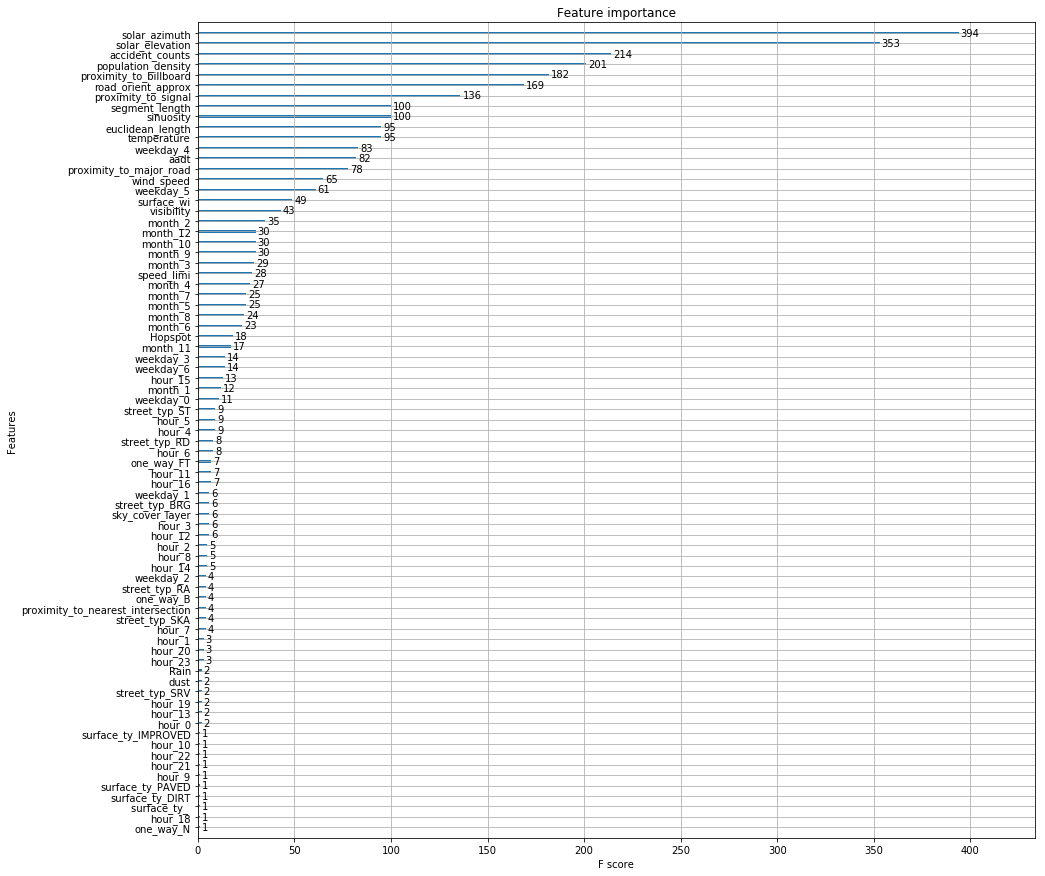

In [13]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [14]:
booster.save_model('new_0001_new.model')

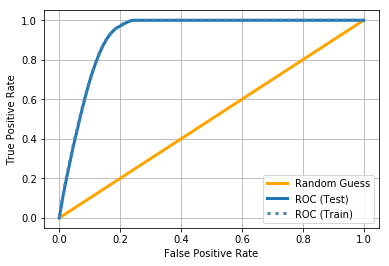

In [15]:
y_pred_test = booster.predict(dtest)

fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(dtrain)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

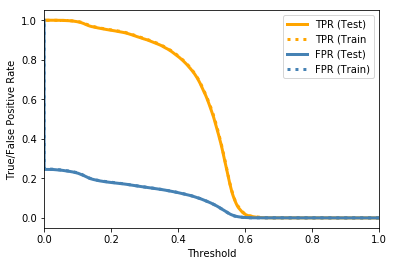

In [16]:
plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive Rate')
plt.legend()

'3.0.3'

<Figure size 1080x1080 with 0 Axes>

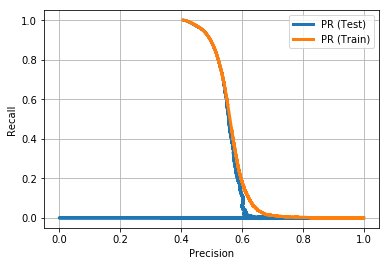

In [17]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(dtest)
y_pred_train = booster.predict(dtrain)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.matplotlib.__version__

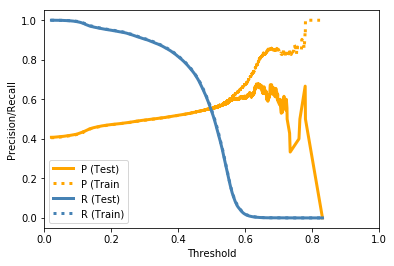

In [18]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()

In [19]:
y_pred_test = booster.predict(dtest) > 0.19
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(dtest)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))

y_pred_train = booster.predict(dtrain) > 0.19
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(dtrain)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))

Test Accuracy: 0.837933248549124
Test F1: 0.6292729953498923
Test Precision: 0.46990819161189784
Test Recall: 0.9522036109013524
Test AUC: 0.9239409514378806
Test AP: 0.5517263571867849
Train Accuracy: 0.8376516021694639
Train F1: 0.6287965053004958
Train Precision: 0.46895353151993685
Train Recall: 0.9539510520914749
Train AUC: 0.9248795345954225
Test AP: 0.5608964936995235


In [20]:
def plot_split_histogram(feature_name):
    hist = booster.get_split_value_histogram(feature_name)
    try:
        i = float_feature_names.index(feature_name)
        fake_data = np.zeros((hist.Count.size,len(float_feature_names)))
        fake_data[:,i] = hist.SplitValue
        hist.loc[:,'SplitValue'] = scaler.inverse_transform(fake_data)[:,i]
    except: pass
    hist.plot(kind='area',x='SplitValue',y='Count')

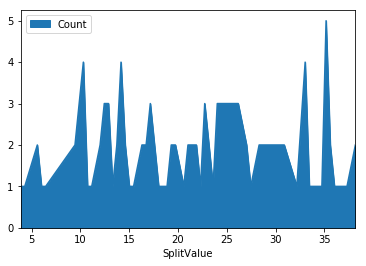

In [21]:
plot_split_histogram('temperature')

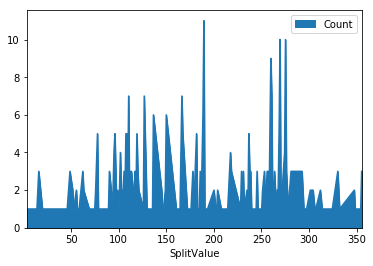

In [22]:
plot_split_histogram('solar_azimuth')

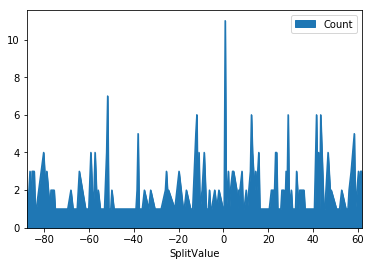

In [23]:
plot_split_histogram('solar_elevation')

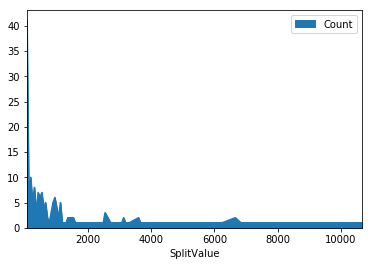

In [24]:
plot_split_histogram('proximity_to_billboard')

# Notebook 3

In [25]:
import pandas as pd
import geopandas as gpd
import time
import pickle
import os
import numpy as np
import xgboost
import pytz
import arcgis
#
#plotting
#'''
from IPython.display import HTML, display
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
#'''

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
mpl.rc('xtick', color='k')
mpl.rc('ytick', color='k')
%matplotlib inline
#'''
import datetime

In [26]:
with open('new__wrangler.pkl','rb') as fp:
    wrangler = pickle.load(fp)

float_scaler_mean = wrangler['float_scaler_mean']
float_scaler_std = wrangler['float_scaler_std']
float_feature_names = wrangler['float_feature_names']
ohe_fields = wrangler['ohe_fields']
feature_names = wrangler['feature_names']   
booster = xgboost.Booster()
booster.load_model('new_0001_new.model')

In [27]:
project_gdb = r'D:\test_2014_2016\test_2014_2016\test_2014_2016.gdb'
collisions_path = os.path.join(project_gdb,'collisions_joined')
road_features_path = os.path.join(project_gdb,'static_features')

In [28]:
r_tz = pytz.timezone('Asia/Riyadh')

In [29]:
road_features = pd.read_csv('training_data/road_featuresr.csv')

In [30]:
collisions =  pd.read_csv('training_data/collisions.csv')

C:\Users\maram\Anaconda3\envs\t\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
tidx = pd.DatetimeIndex(collisions['timestamp']).floor('H')
tidx = tidx.tz_localize(r_tz,ambiguous='NaT')

In [32]:
#collisions['timestamp'] = pd.to_datetime(collisions.timestamp).map(utah_tz.localize)
collisions = collisions.set_index(tidx)
collisions.sort_index(inplace=True)

In [33]:
collisions['hour'] = collisions.index.hour
collisions['weekday'] = collisions.index.weekday
collisions['month'] = collisions.index.month

In [34]:
wdf = pd.read_csv('Riyadh_weather_2014-2019_grouped.csv')

In [35]:
wdf['timestamp'] = pd.to_datetime(wdf.timestamp).map(pytz.utc.localize)
wdf['timestamp'] = wdf['timestamp'].map(lambda x: x.astimezone(r_tz))

In [36]:
wdf = wdf.set_index('timestamp')

In [37]:
road_features.head(10)

,segment_id,OBJECTID,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,street_typ,surface_ty,suf_dir,one_way,speed_limi,surface_wi,pre_dir,aadt,Hopspot,Shape_Leng,sinuosity,euclidean_length,segment_length,at_intersection,near_billboard,road_orient_approx,proximity_to_signal,proximity_to_billboard,proximity_to_nearest_intersection,proximity_to_major_road,population_density,station_id,SHAPE,accident_counts
0,1,1,1,1,1,1,ST,PAVED,,B,30,12.0,,10,40,64.890401,1.000000,64.890401,64.890401,1,0,2.185814,1053.887784,777.477505,0.0,868.212073,64.854611,40438099999,"{'paths': [[[680670.8324999996, 2735152.058], ...",0
1,2,2,1,2,1,2,,DIRT,,,0,15.0,,10,50,101.499796,1.000000,101.499796,101.499796,1,0,2.911898,36121.459430,28517.262540,0.0,11520.340010,0.000021,40478099999,"{'paths': [[[710241.2591000004, 2771071.907500...",0
2,3,3,1,3,1,3,ST,PAVED,,B,30,20.0,,10,100,439.532283,1.000077,439.498395,439.532283,1,0,2.509810,96.769849,208.698728,0.0,0.000000,26.663902,40488099999,"{'paths': [[[668470.1953999996, 2714535.564300...",43
3,4,4,1,4,1,4,,PAVED,,,0,10.0,,10,40,100.991057,1.000000,100.991057,100.991057,1,0,0.599869,4215.404517,2556.766267,0.0,787.336184,0.580848,40441099999,"{'paths': [[[690822.8370000003, 2735025.843000...",0
4,5,5,1,5,1,5,ST,PAVED,,B,30,15.0,,10,100,177.878373,1.000000,177.878340,177.878373,1,0,0.605544,538.720319,1204.747372,0.0,78.445159,84.861792,40438099999,"{'paths': [[[685438.8331000004, 2737051.806500...",0
5,6,6,1,6,1,6,ST,PAVED,,B,30,15.0,,10,40,297.832558,1.000003,297.831545,297.832558,1,0,1.499949,9148.218907,6872.365728,0.0,988.905884,20.768344,40448099999,"{'paths': [[[655297.4611999998, 2717691.933900...",6
6,7,7,1,7,1,7,ST,PAVED,,B,30,15.0,,10,100,229.511369,1.000094,229.489880,229.511369,1,0,0.601041,934.608023,138.044314,0.0,132.720271,91.111844,40438099999,"{'paths': [[[680251.3321000002, 2733290.8082],...",2
7,8,8,1,8,1,8,SKA,PAVED,,B,30,10.0,,10,100,42.998149,1.000000,42.998149,42.998149,1,0,2.209730,64.569174,1185.185381,0.0,0.000000,389.834595,40438099999,"{'paths': [[[674211.7929999996, 2724470.5998],...",0
8,9,9,1,9,1,9,ST,PAVED,,B,30,15.0,,10,40,87.043201,1.000000,87.043201,87.043201,1,0,0.614948,694.252642,509.225784,0.0,561.075890,108.723920,40438099999,"{'paths': [[[678928.574, 2740077.2250999995], ...",0
9,10,10,1,10,1,10,SKA,PAVED,,B,30,10.0,,430863,100,149.889562,1.000007,149.888580,149.889562,1,0,1.758705,1001.581551,664.272689,0.0,197.728475,104.742725,40438099999,"{'paths': [[[671196.4494000003, 2724029.312200...",4


In [38]:
import geopandas as gpd
import json
import numpy as np
from shapely.geometry import LineString, Point, box, mapping
import ast
from pyproj import Proj

In [39]:
paths = road_features.SHAPE.map(lambda x: np.array(ast.literal_eval(x)['paths'][0]))

In [40]:
pathLineStrings = paths.map(LineString)

In [41]:
gdf = gpd.GeoDataFrame(road_features,geometry=pathLineStrings)
gdf.crs = {'init': 'epsg:32638'}
#gdf.crs = {'init': 'epsg:4326'}

In [42]:
gdf.head()

,segment_id,OBJECTID,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,street_typ,surface_ty,suf_dir,one_way,speed_limi,surface_wi,pre_dir,aadt,Hopspot,Shape_Leng,sinuosity,euclidean_length,segment_length,at_intersection,near_billboard,road_orient_approx,proximity_to_signal,proximity_to_billboard,proximity_to_nearest_intersection,proximity_to_major_road,population_density,station_id,SHAPE,accident_counts,geometry
0,1,1,1,1,1,1,ST,PAVED,,B,30,12.0,,10,40,64.890401,1.000000,64.890401,64.890401,1,0,2.185814,1053.887784,777.477505,0.0,868.212073,64.854611,40438099999,"{'paths': [[[680670.8324999996, 2735152.058], ...",0,"LINESTRING (680670.8324999996 2735152.058, 680..."
1,2,2,1,2,1,2,,DIRT,,,0,15.0,,10,50,101.499796,1.000000,101.499796,101.499796,1,0,2.911898,36121.459430,28517.262540,0.0,11520.340010,0.000021,40478099999,"{'paths': [[[710241.2591000004, 2771071.907500...",0,LINESTRING (710241.2591000004 2771071.90750000...
2,3,3,1,3,1,3,ST,PAVED,,B,30,20.0,,10,100,439.532283,1.000077,439.498395,439.532283,1,0,2.509810,96.769849,208.698728,0.0,0.000000,26.663902,40488099999,"{'paths': [[[668470.1953999996, 2714535.564300...",43,LINESTRING (668470.1953999996 2714535.56430000...
3,4,4,1,4,1,4,,PAVED,,,0,10.0,,10,40,100.991057,1.000000,100.991057,100.991057,1,0,0.599869,4215.404517,2556.766267,0.0,787.336184,0.580848,40441099999,"{'paths': [[[690822.8370000003, 2735025.843000...",0,"LINESTRING (690822.8370000003 2735025.843, 690..."
4,5,5,1,5,1,5,ST,PAVED,,B,30,15.0,,10,100,177.878373,1.000000,177.878340,177.878373,1,0,0.605544,538.720319,1204.747372,0.0,78.445159,84.861792,40438099999,"{'paths': [[[685438.8331000004, 2737051.806500...",0,LINESTRING (685438.8331000004 2737051.80650000...


In [43]:
gdf = gdf.to_crs({'init': 'epsg:4326'})

In [44]:
x0 = 900714804574
x1 = -5120900
y0 = 900709927374
y1 = -9998100
SLC = box(x0,y0,x1,y1)

In [45]:
slc_df = gdf[gdf.intersects(SLC)]

In [46]:
slc_df.head()

,segment_id,OBJECTID,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,street_typ,surface_ty,suf_dir,one_way,speed_limi,surface_wi,pre_dir,aadt,Hopspot,Shape_Leng,sinuosity,euclidean_length,segment_length,at_intersection,near_billboard,road_orient_approx,proximity_to_signal,proximity_to_billboard,proximity_to_nearest_intersection,proximity_to_major_road,population_density,station_id,SHAPE,accident_counts,geometry
0,1,1,1,1,1,1,ST,PAVED,,B,30,12.0,,10,40,64.890401,1.000000,64.890401,64.890401,1,0,2.185814,1053.887784,777.477505,0.0,868.212073,64.854611,40438099999,"{'paths': [[[680670.8324999996, 2735152.058], ...",0,LINESTRING (46.78620791303667 24.7202687876490...
1,2,2,1,2,1,2,,DIRT,,,0,15.0,,10,50,101.499796,1.000000,101.499796,101.499796,1,0,2.911898,36121.459430,28517.262540,0.0,11520.340010,0.000021,40478099999,"{'paths': [[[710241.2591000004, 2771071.907500...",0,LINESTRING (47.08384913010781 25.0406890366766...
2,3,3,1,3,1,3,ST,PAVED,,B,30,20.0,,10,100,439.532283,1.000077,439.498395,439.532283,1,0,2.509810,96.769849,208.698728,0.0,0.000000,26.663902,40488099999,"{'paths': [[[668470.1953999996, 2714535.564300...",43,LINESTRING (46.66316186765538 24.5355368953859...
3,4,4,1,4,1,4,,PAVED,,,0,10.0,,10,40,100.991057,1.000000,100.991057,100.991057,1,0,0.599869,4215.404517,2556.766267,0.0,787.336184,0.580848,40441099999,"{'paths': [[[690822.8370000003, 2735025.843000...",0,LINESTRING (46.88651720495255 24.7179008371508...
4,5,5,1,5,1,5,ST,PAVED,,B,30,15.0,,10,100,177.878373,1.000000,177.878340,177.878373,1,0,0.605544,538.720319,1204.747372,0.0,78.445159,84.861792,40438099999,"{'paths': [[[685438.8331000004, 2737051.806500...",0,LINESTRING (46.83357958623989 24.7368486838882...


C:\Users\maram\Anaconda3\envs\t\lib\site-packages\mapclassify\classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
C:\Users\maram\Anaconda3\envs\t\lib\site-packages\mapclassify\classifiers.py:96: UserWarning: Warning: setting k to 3
  Warn('Warning: setting k to %d' % k_q, UserWarning)


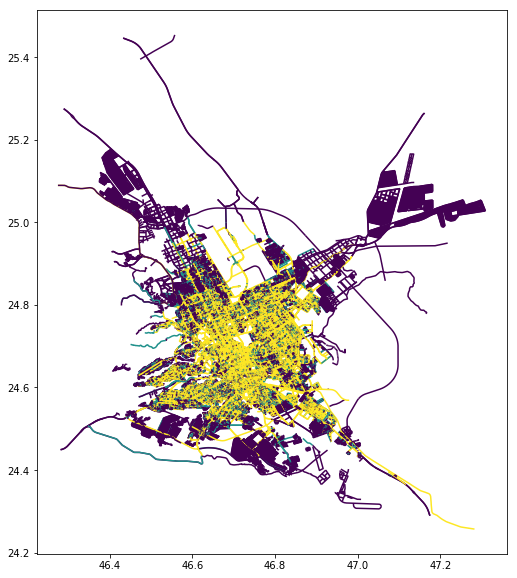

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches((10,10))
#help(gdf.plot)
slc_df['scaled'] = slc_df['accident_counts']
slc_df.plot(ax=ax,column='scaled',scheme='quantiles')

In [48]:
slc_df.head()

,segment_id,OBJECTID,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,street_typ,surface_ty,suf_dir,one_way,speed_limi,surface_wi,pre_dir,aadt,Hopspot,Shape_Leng,sinuosity,euclidean_length,segment_length,at_intersection,near_billboard,road_orient_approx,proximity_to_signal,proximity_to_billboard,proximity_to_nearest_intersection,proximity_to_major_road,population_density,station_id,SHAPE,accident_counts,geometry,scaled
0,1,1,1,1,1,1,ST,PAVED,,B,30,12.0,,10,40,64.890401,1.000000,64.890401,64.890401,1,0,2.185814,1053.887784,777.477505,0.0,868.212073,64.854611,40438099999,"{'paths': [[[680670.8324999996, 2735152.058], ...",0,LINESTRING (46.78620791303667 24.7202687876490...,0
1,2,2,1,2,1,2,,DIRT,,,0,15.0,,10,50,101.499796,1.000000,101.499796,101.499796,1,0,2.911898,36121.459430,28517.262540,0.0,11520.340010,0.000021,40478099999,"{'paths': [[[710241.2591000004, 2771071.907500...",0,LINESTRING (47.08384913010781 25.0406890366766...,0
2,3,3,1,3,1,3,ST,PAVED,,B,30,20.0,,10,100,439.532283,1.000077,439.498395,439.532283,1,0,2.509810,96.769849,208.698728,0.0,0.000000,26.663902,40488099999,"{'paths': [[[668470.1953999996, 2714535.564300...",43,LINESTRING (46.66316186765538 24.5355368953859...,43
3,4,4,1,4,1,4,,PAVED,,,0,10.0,,10,40,100.991057,1.000000,100.991057,100.991057,1,0,0.599869,4215.404517,2556.766267,0.0,787.336184,0.580848,40441099999,"{'paths': [[[690822.8370000003, 2735025.843000...",0,LINESTRING (46.88651720495255 24.7179008371508...,0
4,5,5,1,5,1,5,ST,PAVED,,B,30,15.0,,10,100,177.878373,1.000000,177.878340,177.878373,1,0,0.605544,538.720319,1204.747372,0.0,78.445159,84.861792,40438099999,"{'paths': [[[685438.8331000004, 2737051.806500...",0,LINESTRING (46.83357958623989 24.7368486838882...,0


In [49]:
predTimest = pd.date_range('1/02/2014', periods=7*24, freq='H',tz='Asia/Riyadh')

In [50]:
predTimest

DatetimeIndex(['2014-01-02 00:00:00+03:00', '2014-01-02 01:00:00+03:00',
               '2014-01-02 02:00:00+03:00', '2014-01-02 03:00:00+03:00',
               '2014-01-02 04:00:00+03:00', '2014-01-02 05:00:00+03:00',
               '2014-01-02 06:00:00+03:00', '2014-01-02 07:00:00+03:00',
               '2014-01-02 08:00:00+03:00', '2014-01-02 09:00:00+03:00',
               ...
               '2014-01-08 14:00:00+03:00', '2014-01-08 15:00:00+03:00',
               '2014-01-08 16:00:00+03:00', '2014-01-08 17:00:00+03:00',
               '2014-01-08 18:00:00+03:00', '2014-01-08 19:00:00+03:00',
               '2014-01-08 20:00:00+03:00', '2014-01-08 21:00:00+03:00',
               '2014-01-08 22:00:00+03:00', '2014-01-08 23:00:00+03:00'],
              dtype='datetime64[ns, Asia/Riyadh]', length=168, freq='H')

In [51]:
prediction_time = predTimest[15]

In [52]:
test_df = slc_df.copy()

In [53]:
test_df['timestamp'] = prediction_time
test_df['station_id'] = slc_df.station_id.astype('int64')
test_df['hour'] = prediction_time.hour
test_df['weekday'] = prediction_time.weekday()
test_df['month'] = prediction_time.month

In [54]:
prediction_time.month

1

In [55]:
def add_join_key(df):
    df['join_key'] = df.station_id.map(int).map(str)+df.timestamp.map(datetime.datetime.isoformat)
    df = df.set_index('join_key')
    return df

In [56]:
weath_df = wdf.loc[prediction_time]

In [57]:
test_df = add_join_key(test_df)
weath_df = add_join_key(weath_df.reset_index())

In [58]:
test_df = test_df.join(weath_df.drop(columns=['station_id','timestamp']))

In [59]:
test_df.columns

Index(['segment_id', 'OBJECTID', 'Join_Count', 'TARGET_FID', 'Join_Count_1',
       'TARGET_FID_1', 'street_typ', 'surface_ty', 'suf_dir', 'one_way',
       'speed_limi', 'surface_wi', 'pre_dir', 'aadt', 'Hopspot', 'Shape_Leng',
       'sinuosity', 'euclidean_length', 'segment_length', 'at_intersection',
       'near_billboard', 'road_orient_approx', 'proximity_to_signal',
       'proximity_to_billboard', 'proximity_to_nearest_intersection',
       'proximity_to_major_road', 'population_density', 'station_id', 'SHAPE',
       'accident_counts', 'geometry', 'scaled', 'timestamp', 'hour', 'weekday',
       'month', 'wind_speed', 'visibility', 'temperature', 'Rain',
       'sky_cover_layer', 'dew_point_temperature', 'EXTREME_AIR_TEMPERATURE',
       'dust'],
      dtype='object')

In [60]:
def make_test_set(df,wrangler):
    float_scaler_mean = wrangler['float_scaler_mean']
    float_scaler_std = wrangler['float_scaler_std']
    float_feature_names = wrangler['float_feature_names']
    ohe_fields = wrangler['ohe_fields']
    feature_names = wrangler['feature_names']
    print(len(feature_names))
    df_ohe = pd.get_dummies(df,columns=ohe_fields)

    float_features = df.xs(float_feature_names,axis=1).values
    float_features = (float_features - float_scaler_mean) / float_scaler_std
    for i,fname in enumerate(float_feature_names):
        df_ohe[fname] = float_features[:,i]
        
    empty_features = list(set(feature_names) - set(df_ohe.columns.tolist()))
    
    #for f in empty_features:
    #    df_ohe[f] = 0
    
    df_ohe = df_ohe[feature_names]#.drop(columns=['SegID.1','geometry','SHAPE']+drop_columns,errors='ignore')
    
    #print(df_ohe.columns)
    #print(df_ohe.columns.tolist())
    X = df_ohe.values
    feature_names = df_ohe.columns.tolist()
    return X, feature_names

In [77]:
import matplotlib.colors as c
help(c.LinearSegmentedColormap.from_list)
cmap = c.LinearSegmentedColormap.from_list('traffic',['g','g','g','y','orange','r','darkred'])

Help on function from_list in module matplotlib.colors:

from_list(name, colors, N=256, gamma=1.0)
    Make a linear segmented colormap with *name* from a sequence
    of *colors* which evenly transitions from colors[0] at val=0
    to colors[-1] at val=1.  *N* is the number of rgb quantization
    levels.
    Alternatively, a list of (value, color) tuples can be given
    to divide the range unevenly.



In [78]:
'''
%matplotlib
fig,ax = plt.subplots()
for i,pt in enumerate(predTimest[:72]):
    test_df = slc_df.copy()
    test_df['timestamp'] = pt
    test_df['station_id'] = slc_df.station_id.astype('int64')
    test_df['hour'] = prediction_time.hour
    test_df['weekday'] = prediction_time.weekday()
    test_df['month'] = prediction_time.month
    
    weath_df = wdf.loc[pt]
    test_df = add_join_key(test_df)
    weath_df = add_join_key(weath_df.reset_index())
    
    test_df = test_df.join(weath_df.drop(columns=['station_id','timestamp']))
    X,names = make_test_set(test_df,wrangler)
    xm = xgboost.DMatrix(X[:,:],feature_names=names)
    
    pred = booster.predict(xm)
    test_df['probability'] = np.minimum(pred,0.50)
    test_collisions = collisions[(pt - datetime.timedelta(seconds=0)).isoformat():(pt + datetime.timedelta(seconds=3600)).isoformat()]
    fig,ax = plt.subplots()
    
    fig.set_size_inches((15,15))
    test_df.plot(ax=ax,column='probability',cmap=cmap,linewidth=3,alpha=1)
    plt.gca().set_facecolor('k')
    #plt.imshow(np.array([[test_df.probability.min(),test_df.probability.max()]]),origin='lower')
    test_collisions.plot.scatter(x='DDLon',y='DDLat',ax=ax,s=100,marker='*',color='r',zorder=6e99)
    ax.set_xbound(lower=x0,upper=x1)
    ax.set_ybound(lower=y0,upper=y1)
    #plt.colorbar()
    plt.savefig('{}.png'.format(i))
   
'''

"\n%matplotlib\nfig,ax = plt.subplots()\nfor i,pt in enumerate(predTimest[:72]):\n    test_df = slc_df.copy()\n    test_df['timestamp'] = pt\n    test_df['station_id'] = slc_df.station_id.astype('int64')\n    test_df['hour'] = prediction_time.hour\n    test_df['weekday'] = prediction_time.weekday()\n    test_df['month'] = prediction_time.month\n    \n    weath_df = wdf.loc[pt]\n    test_df = add_join_key(test_df)\n    weath_df = add_join_key(weath_df.reset_index())\n    \n    test_df = test_df.join(weath_df.drop(columns=['station_id','timestamp']))\n    X,names = make_test_set(test_df,wrangler)\n    xm = xgboost.DMatrix(X[:,:],feature_names=names)\n    \n    pred = booster.predict(xm)\n    test_df['probability'] = np.minimum(pred,0.50)\n    test_collisions = collisions[(pt - datetime.timedelta(seconds=0)).isoformat():(pt + datetime.timedelta(seconds=3600)).isoformat()]\n    fig,ax = plt.subplots()\n    \n    fig.set_size_inches((15,15))\n    test_df.plot(ax=ax,column='probability',cmap

In [65]:
wrangler

{'float_scaler_mean': StandardScaler(copy=True, with_mean=True, with_std=True),
 'float_scaler_std': array([[-0.31354463,  1.12933509,  2.49666056, ..., -1.13645991,
          0.20248799, -1.16429582],
        [-0.31354463,  1.12933509,  2.49666056, ..., -1.13645991,
          0.20248799, -1.16429582],
        [-0.37602202,  1.12933509,  2.33939491, ..., -0.59341191,
          0.83697439, -0.79398197],
        ...,
        [-0.40423761, -1.15862856, -0.51022884, ..., -1.59713345,
         -1.7632809 , -0.42366811],
        [-0.40423761, -0.01464673, -0.51022884, ..., -1.59713345,
         -1.7632809 , -1.16429582],
        [-0.40423761, -0.01464673, -0.51022884, ..., -1.59713345,
         -1.7632809 , -1.16429582]]),
 'float_feature_names': ['accident_counts',
  'speed_limi',
  'aadt',
  'surface_wi',
  'sinuosity',
  'euclidean_length',
  'segment_length',
  'road_orient_approx',
  'Rain',
  'dust',
  'temperature',
  'visibility',
  'wind_speed',
  'proximity_to_billboard',
  'proxim

# HERE IS THE ERROR

AND when i remove "['solar_azimuth', 'solar_elevation'] from index" i gote 
the secend error below

In [63]:
X,names = make_test_set(test_df,wrangler)
print (X.shape)
print (X[0])

86


KeyError: "['solar_azimuth', 'solar_elevation'] not in index"

In [ ]:
X,names = make_test_set(test_df,wrangler)
print (X.shape)
print (X[0])

In [ ]:
82
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-59-a9fdb4a2e66f> in <module>
----> 1 X,names = make_test_set(test_df,wrangler)
      2 print (X.shape)
      3 print (X[0])

<ipython-input-56-18c1867fc096> in make_test_set(df, wrangler)
      9 
     10     float_features = df.xs(float_feature_names,axis=1).values
---> 11     float_features = (float_features - float_scaler_mean) / float_scaler_std
     12     for i,fname in enumerate(float_feature_names):
     13         df_ohe[fname] = float_features[:,i]

TypeError: unsupported operand type(s) for -: 'int' and 'StandardScaler'

In [85]:
wrangler

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'float_scaler_std': array([[ 0.21455446,  0.26407511, -0.16188289, ..., -0.78287998,
         -0.3925233 ,  0.49250211],
        [ 0.21455446,  0.26407511, -0.16188289, ..., -0.78287998,
         -0.3925233 ,  0.49250211],
        [-0.67694958,  0.26407511,  1.6593147 , ..., -0.67257754,
         -0.93315931, -1.79970052],
        ...,
        [-0.20094045, -1.88285298, -0.71647534, ...,  1.19367077,
         -0.89826681,  0.49250211],
        [ 1.08822842,  0.26407511,  0.32419469, ..., -0.71893378,
         -0.38134061,  0.49250211],
        [-0.69099752,  0.26407511, -0.263122  , ...,  9.84106895,
         -0.92965953, -2.25814104]]),
 'float_feature_names': ['accident_counts',
  'speed_limit',
  'aadt',
  'surface_width',
  'sinuosity',
  'euclidean_length',
  'segment_length',
  'road_orient_approx',
  'Rain',
  'dust',
  'temperature',
  'visibility',
  'wind_speed',
  'proximity_to_billboard',
  'proximity_to_

In [ ]:
xm = xgboost.DMatrix(X[:,:],feature_names=names[:])

In [ ]:
pred = booster.predict(xm)

In [ ]:
plt.figure()
plt.hist(pred,50)

In [ ]:
test_df['probability'] = pred*100


In [ ]:
test_collisions = collisions[(prediction_time - datetime.timedelta(seconds=0)).isoformat():(prediction_time + datetime.timedelta(seconds=3600)).isoformat()]
